# IMPORTING LIBRARIES AND MODULES

In [1]:
import timm # PyTorch Image Models
import os 
import pandas as pd
import torch
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOADING DATA DIRECTORY
data_dir = "/home/tungnguyendinh/.fastai/data/pascal_2007/"
print(os.listdir(data_dir))

# RETRIEVE ALL CLASSES
VOC_CLASSES = pd.read_csv(data_dir + "train.csv")['labels'].str.split(' ', expand=True).stack().unique().tolist()
print(VOC_CLASSES)

['test.json', 'valid.json', 'train.csv', 'test.csv', 'train.json', 'segmentation', 'test', 'train']
['chair', 'car', 'horse', 'person', 'bicycle', 'cat', 'dog', 'train', 'aeroplane', 'diningtable', 'tvmonitor', 'bird', 'bottle', 'motorbike', 'pottedplant', 'boat', 'sofa', 'sheep', 'cow', 'bus']


In [3]:
# HELPER FUNCTIONS 
# encode labels
def encode_labels(labels, classes = VOC_CLASSES):
    target = torch.zeros(len(classes))
    for label in labels:
        target[classes.index(label)] = 1
    return target

# decode labels
def decode_labels(target, classes = VOC_CLASSES, threshold=0.5):
    labels = []
    for i, prob in enumerate(target):
        if prob > threshold:
            labels.append(classes[i])

    return ' '.join(labels)

In [4]:
# Dataset 
from torchvision.io import read_image
#Create Custom dataset class for Pascal_2007
class PascalDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1].split(" ")
        if self.transform:
            image = self.transform(image)
        return image, encode_labels(labels)

In [5]:
temp = PascalDataset(img_dir = data_dir + "train", annotations_file = data_dir + "train.csv")
print(temp[0][0])

tensor([[[ 10,  13,  10,  ..., 163, 162, 161],
         [  3,   7,  11,  ..., 163, 163, 163],
         [ 45,  24,  15,  ..., 165, 165, 165],
         ...,
         [ 31,  36,  29,  ...,  58,  61,  58],
         [ 36,  34,  38,  ...,  66,  70,  70],
         [ 49,  60,  73,  ...,  64,  68,  69]],

        [[ 10,  13,  10,  ..., 188, 187, 186],
         [  4,   9,  11,  ..., 188, 188, 188],
         [ 49,  28,  16,  ..., 190, 190, 190],
         ...,
         [ 12,  17,  10,  ...,  72,  72,  71],
         [  9,   7,   8,  ...,  80,  83,  83],
         [ 17,  22,  25,  ...,  79,  83,  84]],

        [[ 10,  13,  10,  ..., 195, 194, 193],
         [  6,   8,  13,  ..., 195, 195, 195],
         [ 52,  29,  20,  ..., 197, 197, 197],
         ...,
         [  8,  11,   3,  ..., 101, 104, 103],
         [  2,   0,   0,  ..., 109, 115, 115],
         [  6,  11,  13,  ..., 108, 112, 113]]], dtype=torch.uint8)


In [6]:
# CONVERT TO LIGHTNING DATA MODULE
class PascalVoC2007(pl.LightningDataModule):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir

        # Mean and Std by ImageNet
        MEAN =[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
        STD =[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]  

        # train transforms
        self.train_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((300, 300)),
            T.RandomChoice([
                                T.ColorJitter(brightness=(0.9, 1.1)),
                                T.RandomGrayscale(p = 0.25)
                                ]),
            T.RandomHorizontalFlip(p = 0.25),
            T.RandomRotation(25),
            T.ToTensor(), 
            T.Normalize(mean = MEAN, std = STD),
            ])
        
        # test transforms
        self.eval_transform = T.Compose([
            T.ToPILImage(),
            T.Resize((300, 300)),
            T.ToTensor(),
            T.Normalize(mean = MEAN, std = STD)
            ])
        
        
    def setup(self):
        # Merge val and train to fit all data
        self.train_data = PascalDataset(img_dir = data_dir + "train", annotations_file = data_dir + "train.csv", transform=self.train_transform)
        # Use test data for evaluation 
        self.test_data = PascalDataset(img_dir = data_dir + "test", annotations_file = data_dir + "test.csv", transform=self.eval_transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.test_data, batch_size=32, num_workers=4) 

dataset = PascalVoC2007(data_dir = data_dir)
dataset.setup()

In [7]:
# MODEL
from typing import Any
from pytorch_lightning.utilities.types import STEP_OUTPUT
import timm
from torchmetrics.classification import MultilabelAccuracy
from lightning.pytorch.loggers import TensorBoardLogger

model = timm.create_model('resnet18', pretrained=False, num_classes=len(VOC_CLASSES))

# PyTorch Lightning Module
class Resnet18(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.BCEWithLogitsLoss()
        self.accuracy = MultilabelAccuracy(num_labels=len(VOC_CLASSES), average='none')

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer
    
    def _calculate(self, batch):
        input, target = batch
        pred = self.model(input)
        loss = self.criterion(pred, target)
        acc = self.accuracy(pred, target)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self._calculate(batch)
        return {
            'loss': loss,
            'acc': acc
        }
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._calculate(batch)
        return {
            'loss': loss,
            'acc': acc
        }

In [8]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.utils import make_grid

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='inferno')

class ResnetCallback(Callback):
    def __init__(self, load_trained = False):
        super().__init__()
        self.train_outputs = []
        self.val_outputs = []
        self.load_trained = load_trained

    def on_fit_start(self, trainer, pl_module):
        if self.load_trained:
            if os.path.exists('/home/phongtnh/PIXTA_TRAINING/model_15.pth'):
                # load pretrained model from pytorch checkpoint
                checkpoint = torch.load('/home/phongtnh/PIXTA_TRAINING/model_15.pth')['model_state_dict']
                model_dict = pl_module.state_dict()
                pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
                model_dict.update(pretrained_dict)
                pl_module.load_state_dict(model_dict)
            else:
                print('No pretrained model found')

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused = 0):
        self.train_outputs.append(outputs)
        
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0):
        self.val_outputs.append(outputs)

    def on_train_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.train_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.train_outputs]).mean()
        
        pl_module.logger.experiment.add_scalar("Loss/train",
                                          avg_loss,
                                          pl_module.current_epoch)
        
        pl_module.logger.experiment.add_scalar("Accuracy/train",
                                          avg_acc,
                                          pl_module.current_epoch)
        
    def on_validation_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.val_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.val_outputs]).mean()
        self.log('val_loss', avg_loss)
        
        pl_module.logger.experiment.add_scalar("Loss/val",
                                            avg_loss,
                                            pl_module.current_epoch)
        pl_module.logger.experiment.add_scalar("Accuracy/val",
                                            avg_acc,
                                            pl_module.current_epoch)
        # Output epoch number, loss, acc
        print('Epoch: {}, Loss: {}, Accuracy: {}'.format(pl_module.current_epoch, avg_loss, avg_acc))
        
    def on_fit_end(self, trainer, pl_module):
        filter = pl_module.model.state_dict()['conv1.weight'].data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()
        

              

In [9]:
Resnet = Resnet18(model)
logger = TensorBoardLogger('runs', name="Resnet18_Lightning")
trainer = pl.Trainer(accelerator='gpu',
                     max_epochs=1,
                     devices=[1],
                     logger=logger,
                     callbacks=[ResnetCallback(load_trained=True)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | criterion | BCEWithLogitsLoss  | 0     
2 | accuracy  | MultilabelAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.747    Total estimated model params size (MB)


No pretrained model found


Sanity Checking: 0it [00:00, ?it/s]

Epoch: 0, Loss: 0.6949320435523987, Accuracy: 0.47734376788139343


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch: 0, Loss: 0.25357839465141296, Accuracy: 0.9176817536354065


`Trainer.fit` stopped: `max_epochs=1` reached.


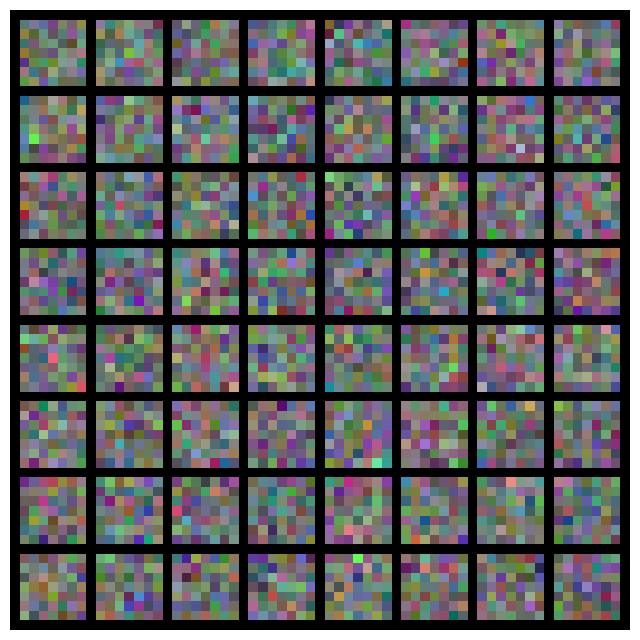

In [10]:
trainer.fit(Resnet, dataset.train_dataloader(), dataset.val_dataloader())